In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import hstack

from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet

from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression, ElasticNetCV
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn import preprocessing
from scipy.stats import skew
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

plt.style.use('seaborn')
%matplotlib inline

## Import Data

In [2]:
#import train and test dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

Train shape: (1460, 81)
Test shape: (1459, 80)


## Remove Outliers
Authors informed to remove cheap and expensive house, hence the ground live area of houses that more than 4000 will be removed. 

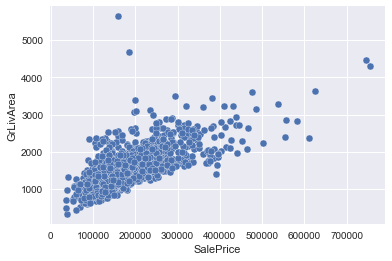

In [3]:
plt.scatter(x=train.SalePrice, y=train.GrLivArea, edgecolors='white')
plt.xlabel('SalePrice')
plt.ylabel('GrLivArea')
plt.show()

In [4]:
train = train[train.GrLivArea<4000]
train = train[train.SalePrice<700000]

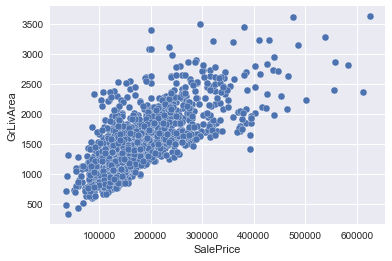

In [5]:
plt.scatter(x=train.SalePrice, y=train.GrLivArea, edgecolors='white')
plt.xlabel('SalePrice')
plt.ylabel('GrLivArea')
plt.show()

In [6]:
print(f'New train shape: {train.shape}')

New train shape: (1456, 81)


In [7]:
#Concatenate train and test set
df_all = pd.concat([train.drop(columns=['SalePrice', 'Id']), test.drop(columns='Id')])
original_col = train.drop(columns=['SalePrice', 'Id']).columns
print(f'Concated shape: {df_all.shape}')
df_all = df_all.drop(columns=['Electrical'])

Concated shape: (2915, 79)


## Missing Value

<AxesSubplot:>

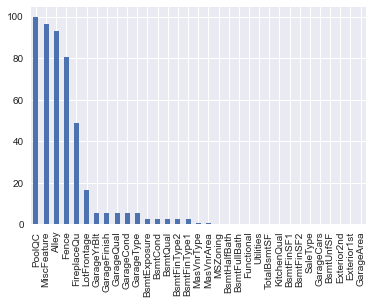

In [8]:
# Missing Value
null_sum = df_all.isnull().sum().sort_values(ascending=False)
(null_sum[null_sum > 0]/(df_all.shape[0])*100).plot.bar()

In [9]:
# Dropping features that have missing value > 20%
null_perc = (null_sum[null_sum > 0]/(df_all.shape[0])*100)
df_all = df_all.drop(columns=null_perc[null_perc>20].index)

In [10]:
# Replacing missing value in features that has missing value < 20%
for c in list(null_perc[null_perc<=20].index):
    if df_all[c].dtype == 'object':
        df_all[c] = df_all[[c]].replace(np.NAN, df_all[c].mode()[0])
    else:
        df_all[c] = df_all[c].replace(np.NAN, df_all[c].mean())

# Double check for missing value
print(df_all.isnull().sum()[df_all.isnull().sum() > 0])

Series([], dtype: int64)


## Feature Engineering
### 1. Simplify Categorical Features 

There are few categorical features can be simplified, 

eg: Basement Quality (BsmtQual) is rated by Excellent('Ex'), Good('Gd'), Average/Typical('TA'), Fair('Fa'), Poor('Po'), No Basement('NA'). 
Therefore, it can be simplified by replacing to numbers Ex:5, Gd:4, TA:3, Fa:2, Po:1, NA:0

In [11]:
sim_qual = ['BsmtFinType1','BsmtFinType2','ExterQual','ExterCond','BsmtQual','BsmtCond',
            'HeatingQC','KitchenQual','GarageCond','GarageQual','GarageFinish', 'BsmtExposure','PavedDrive']

In [12]:
count = 0
for c in sim_qual:
    if (count<2):
        df_all[c] = df_all[c].replace(dict(GLQ=6, ALQ=5, BLQ=4, Rec=3, LwQ=2, Unf=1, NA=0))
    if (count>=2 and count<10):
        df_all[c] = df_all[c].replace(dict(Ex=5, Gd=4, TA=3, Fa=2, Po=1, NA=0))
    if (count == 10):
        df_all[c] = df_all[c].replace(dict(Fin=3, RFn=2, Unf=1, NA=0))
    if (count == 11):
        df_all[c] = df_all[c].replace(dict(Gd=4, Av=3, Mn=2, No=1, NA=0))
    if (count == 12):
        df_all[c] = df_all[c].replace(dict(Y=2, P=1, N=0))
    print(f'count: {count} ---- Simplified feature : {c}')
    count+=1

count: 0 ---- Simplified feature : BsmtFinType1
count: 1 ---- Simplified feature : BsmtFinType2
count: 2 ---- Simplified feature : ExterQual
count: 3 ---- Simplified feature : ExterCond
count: 4 ---- Simplified feature : BsmtQual
count: 5 ---- Simplified feature : BsmtCond
count: 6 ---- Simplified feature : HeatingQC
count: 7 ---- Simplified feature : KitchenQual
count: 8 ---- Simplified feature : GarageCond
count: 9 ---- Simplified feature : GarageQual
count: 10 ---- Simplified feature : GarageFinish
count: 11 ---- Simplified feature : BsmtExposure
count: 12 ---- Simplified feature : PavedDrive


In [13]:
#Getting numerical and categorical features
numerical_features = [f for f in df_all.columns if df_all.dtypes[f] != 'object']
categorical_features = [f for f in df_all.columns if df_all.dtypes[f] == 'object']

In [14]:
print(f'Numerical features : {numerical_features}\n')
print(f'Categorical features : {categorical_features}')

Numerical features : ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

Categorical features : ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Fu

### 2. Binning Year Features 

In [15]:
col = ['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt']
for c in col:
    df_all[c] = pd.qcut(df_all[c], 10, duplicates='drop')

In [16]:
#     Encode categorical features to numeric feature
for c in col:
    df_all[c] = preprocessing.LabelEncoder().fit_transform(df_all[c].values)

In [17]:
#     Check values
df_all[col] = df_all[col]
df_all[col].head()

,YearBuilt,YearRemodAdd,YrSold,GarageYrBlt
0,7,6,1,7
1,5,2,0,4
2,7,5,1,7
3,0,1,0,6
4,7,5,1,7


### 3. Combination Features

In [18]:
#Total Lot Area
df_all['TotalLot'] = df_all['LotFrontage'] + df_all['LotArea']

#Overall House Quality&Condition
# df_all['Overall'] = df_all['OverallCond'] + df_all['OverallQual']

#Total number of basement bathroom
df_all['BsmtBath'] = df_all['BsmtFullBath'] + df_all['BsmtHalfBath']

#Total number of bathroom above grade
df_all['Bath'] = df_all['FullBath'] + df_all['HalfBath']

#total number of bathroom
df_all['TotalBath'] = (df_all['FullBath'] + 0.5*df_all['HalfBath'] 
                        + df_all['BsmtFullBath'] + 0.5*df_all['BsmtHalfBath'])

#Total Basement Fin SF
df_all['TotalBsmtFinSF'] = df_all['BsmtFinSF1'] + df_all['BsmtFinSF2']

#Total Finished Squared feet
df_all['TotalFinSF'] = df_all['BsmtFinSF1'] + df_all['BsmtFinSF2'] + df_all['1stFlrSF'] + df_all['2ndFlrSF']

# Total SF for house (incl. basement)
df_all["AllSF"] = df_all["GrLivArea"] + df_all["TotalBsmtSF"]

# Total SF for 1st + 2nd floors
df_all["AllFlrsSF"] = df_all["1stFlrSF"] + df_all["2ndFlrSF"]

#Total Basement Unfinish SF and Low Quality Finished SF
df_all['Total_BsmtUnfSf_LowQualFinSF'] = df_all['BsmtUnfSF'] + df_all['LowQualFinSF']

#Total Porch SF
df_all['TotalPorchSF'] = (df_all['OpenPorchSF'] + df_all['3SsnPorch'] + df_all['EnclosedPorch'] 
                            + df_all['ScreenPorch'] + df_all['WoodDeckSF'])
df_all = df_all.drop(columns=['OpenPorchSF','3SsnPorch','EnclosedPorch','ScreenPorch','WoodDeckSF'])

#Garage
df_all['GarageArea'] = df_all['GarageArea'].apply(lambda x: 1 if x>0 else 0)

#Pool
df_all['PoolArea'] = df_all['PoolArea'].apply(lambda x: 1 if x>0 else 0)


In [19]:
#Overall House Quality and Condition Score
df_all['OverallScore'] = df_all['OverallCond'] * df_all['OverallQual']

#Overall Kitchen Score 
df_all['KitchenScore'] = df_all['KitchenAbvGr'] * df_all['KitchenQual']

#Overall Exter Score
df_all['ExterScore'] = df_all['ExterCond'] * df_all['ExterQual']

#Basement Finished Type Score
df_all['BsmtFinTypeScore'] = (df_all['BsmtFinType1'] + df_all['BsmtFinType2']) * df_all['BsmtExposure']

#Basement Score
df_all['BsmtScore'] = df_all['BsmtQual'] * df_all['BsmtCond'] 

#Overall Garage Score
df_all['GarageScore'] = df_all['GarageQual'] * df_all['GarageCond']

In [20]:
#Scoring multiply
scoring_multiply = ['OverallScore', 'KitchenScore', 'ExterScore', 'BsmtFinTypeScore', 'BsmtScore', 'GarageScore']
for c in range(0,5):
    for updated in range(1,len(scoring_multiply)):
        name = scoring_multiply[0]+'_and'+scoring_multiply[updated]
        value = df_all[scoring_multiply[0]] + df_all[scoring_multiply[updated]]
        df_all[name] = value
        print('Feature created: ',name)
    scoring_multiply.remove(scoring_multiply[0])

Feature created:  OverallScore_andKitchenScore
Feature created:  OverallScore_andExterScore
Feature created:  OverallScore_andBsmtFinTypeScore
Feature created:  OverallScore_andBsmtScore
Feature created:  OverallScore_andGarageScore
Feature created:  KitchenScore_andExterScore
Feature created:  KitchenScore_andBsmtFinTypeScore
Feature created:  KitchenScore_andBsmtScore
Feature created:  KitchenScore_andGarageScore
Feature created:  ExterScore_andBsmtFinTypeScore
Feature created:  ExterScore_andBsmtScore
Feature created:  ExterScore_andGarageScore
Feature created:  BsmtFinTypeScore_andBsmtScore
Feature created:  BsmtFinTypeScore_andGarageScore
Feature created:  BsmtScore_andGarageScore


### 4. Creating New Polynomial Features 

In [21]:
numerical_features = [f for f in df_all.columns if df_all.dtypes[f] != 'object']    
# train = pd.concat([train[['Id','SalePrice']], df_all[:1456]], axis=1)

In [22]:
numerical_features.append('SalePrice')

# #Removing categorical features in numerical values
col.extend(['GarageArea', 'PoolArea', 'MoSold'])
for c in col:
    numerical_features.remove(c)

# #Calculating the correlation of each feature toward SalePrice
corr = train[numerical_features].corr()
corr.sort_values(['SalePrice'], ascending=True, inplace=True)
plt.figure(figsize=(15, 15))
plt.barh(y=corr.SalePrice.index, width=corr.SalePrice)
plt.title('Correlation towards Sale Price')
plt.show()

KeyError: "['TotalLot', 'BsmtBath', 'Bath', 'TotalBath', 'TotalBsmtFinSF', 'TotalFinSF', 'AllSF', 'AllFlrsSF', 'Total_BsmtUnfSf_LowQualFinSF', 'TotalPorchSF', 'OverallScore', 'KitchenScore', 'ExterScore', 'BsmtFinTypeScore', 'BsmtScore', 'GarageScore', 'OverallScore_andKitchenScore', 'OverallScore_andExterScore', 'OverallScore_andBsmtFinTypeScore', 'OverallScore_andBsmtScore', 'OverallScore_andGarageScore', 'KitchenScore_andExterScore', 'KitchenScore_andBsmtFinTypeScore', 'KitchenScore_andBsmtScore', 'KitchenScore_andGarageScore', 'ExterScore_andBsmtFinTypeScore', 'ExterScore_andBsmtScore', 'ExterScore_andGarageScore', 'BsmtFinTypeScore_andBsmtScore', 'BsmtFinTypeScore_andGarageScore', 'BsmtScore_andGarageScore'] not in index"

In [ ]:
# Create Polynomials Features for top 15 features correlated to SalePrice
for c in corr.SalePrice.sort_values(ascending=False).index[1:15]:
    df_all[c + '_s2'] = df_all[c] ** 2
    df_all[c + '_s3'] = df_all[c] ** 3
    df_all[c + '_sqrt'] = np.sqrt(df_all[c])
    print(f'Feature created: {c}_s2, {c}_s3, {c}_sqrt')

### 5. Checking Skewness
High skewness feature is bad for linear model as it deviates from the normal distribution. There are 3 ways to transform skewed data to normally distributed data:
1. Log transformation
2. Power transformation
3. Exponential transformation

article: https://www.analyticsvidhya.com/blog/2020/07/what-is-skewness-statistics/

In [ ]:
plt.hist(x=train.SalePrice, bins=25)
plt.xlabel('SalePrice')
plt.show()

The sale price is seemed that it does not follow normal distribution.

In [ ]:
train['SalePrice'] = np.log1p(train.SalePrice)
plt.hist(x=train.SalePrice, bins=25)
plt.xlabel('SalePrice')
plt.show()

After log transformation, the sale price is less skewness and more tend to normal distribution.
Same goes to other numerical features that have high skewness require log transformation before inputting to linear model

In [ ]:
numerical_features.remove('SalePrice')

#Checking skewness of each numerical feaure
skewness = (df_all[numerical_features]).apply(lambda x: skew(x))

#Log transform feature that its skewness > 0.5
skewness = skewness[abs(skewness) > 0.5]
skewness.sort_values(ascending=True, inplace=True)
df_all[skewness.index] = np.log1p(df_all[skewness.index])

In [ ]:
plt.figure(figsize=(15, 10))
plt.barh(y=skewness.index, width=skewness)
plt.title('Skewness')
plt.show()

### 6. Dummy Features 
Dummy variable uses numerical value of 0 and 1 to represent the presence or absent in the categorical attribute.

article: https://conjointly.com/kb/dummy-variables/,
         https://stattrek.com/multiple-regression/dummy-variables.aspx

In [ ]:
categorical_features = [f for f in df_all.columns if df_all.dtypes[f] == 'object']

print(f'Before dummy feature: {df_all.shape}')
df_all = pd.get_dummies(df_all, columns=categorical_features)
print(f'Before dummy feature: {df_all.shape}')

## Modelling
Blending Ensemble model will be used in 

In [ ]:
#Retrieving train and test from df_all
y = train.SalePrice
train = df_all[:1456]
test = df_all[1456:]
print(f'Y shape\t\t: {y.shape}')
print(f'Train shape\t: {train.shape}')
print(f'Test shape\t: {test.shape}')
print(f'Total features\t: {train.shape[1]}')

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train, y, test_size = 0.30, random_state=0)
print(f'X_train : {X_train.shape}')
print(f'X_test : {X_val.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test : {y_val.shape}')

In [ ]:
stdSc = StandardScaler()
X_train = pd.DataFrame(stdSc.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val = pd.DataFrame(stdSc.transform(X_val), columns=X_val.columns, index=X_val.index)

In [ ]:
alphas=[0.001,0.003,0.01,0.03,0.1,0.3,1,3]
def get_models():
    models = list()
    models.append(('elasticNet', ElasticNetCV(l1_ratio=0.3, n_alphas = 1, 
                                              alphas=alphas, max_iter=300000, tol=1e-6, cv=10)))
    models.append(('lasso', LassoCV(alphas=alphas, n_alphas=1,
                                    max_iter=400000, tol=1e-6, cv=10)))
    models.append(('Ridge', Ridge(alpha=300, tol=1e-9)))
    models.append(('xgboost', XGBRegressor(n_estimators=500,
                                             objective='reg:squarederror',
                                             max_depth=5,
                                             nthread=-1,
                                             eta=0.1, 
                                             subsample=0.5,
                                             colsample_bytree=0.9,
                                             min_child_weight=0,
                                             reg_lambda=0.001,
                                             reg_alpha=0.001
                                            )))
    models.append(('lightgbm', LGBMRegressor(boosting_type='goss',
                                              objective='regression',
                                              learning_rate=0.1,
                                              n_estimators=500,
                                              colsample_bytree=0.5,
                                              feature_fraction_bynode=0.7,
                                              feature_fraction_seed=np.random.randint(10),
                                              num_leaves=15,
                                              reg_alpha=0.003,
                                              reg_lambda=0.01,
                                             
                                             )))
    return models

In [ ]:
def fit_ensemble(models, X_train, X_val, y_train, y_val):
    # fit all models on the training set and predict on hold out set
    meta_X = list()
    for _, model in models:
        # fit in training set
        print(model)
        model.fit(X_train, y_train)
        #predict hold-out set
        yhat = model.predict(X_val)
        # reshape predictions into a matrix with one column
        yhat = yhat.reshape(len(yhat), 1)
        # store predictions as input for blending
        meta_X.append(yhat)
        
    # create 2d array from predictions, each set is an input feature
    meta_X = hstack(meta_X)
    # define blending model
#     blender =  RandomForestRegressor(bootstrap=True,
#                                     random_state=1,
#                                     min_samples_leaf=5,
#                                     min_samples_split=2,  
#                                     max_depth=15,
#                                     max_features='sqrt',
#                                     )
#     blender = LinearRegression()
    blender =  StackingRegressor(estimators=models,
                                 final_estimator=RandomForestRegressor(bootstrap=True,
                                                                        random_state=1,
                                                                        min_samples_leaf=5,
                                                                        min_samples_split=2,  
                                                                        max_depth=15,
                                                                        max_features='sqrt',
                                                                        ),
#                                  final_estimator=models[3][1],
                                 cv=10)
    # fit on predictions from base models
    blender.fit(meta_X, y_val)
    return blender

In [ ]:
# make a prediction with the blending ensemble
def predict_ensemble(models, blender, X):
    # make predictions with base models
    meta_X = list()
    for _, model in models:
        # predict with base model
        yhat = model.predict(X)
        # reshape predictions into a matrix with one column
        yhat = yhat.reshape(len(yhat), 1)
        # store prediction
        meta_X.append(yhat)
    # create 2d array from predictions, each set is an input feature
    meta_X = hstack(meta_X)
    
    stack_gen = blender.predict(meta_X)
    stack_gen = np.reshape(stack_gen, (-1,1))
    
    meta_X = np.concatenate((meta_X, stack_gen), axis=1)
    coeff = np.array([0.15,0.15,0.15,0.15,0.15,0.25])
    predict = meta_X * coeff
    predict = np.sum(predict, axis=1)
    
#     predict = blender.predict(meta_X)
    
    return predict

In [ ]:
# create the base models
models = get_models()
# train the blending ensemble
blender = fit_ensemble(models, X_train, X_val, y_train, y_val)

In [ ]:
for name, model in models:
    # fit the model on the training dataset
    model.fit(X_train, y_train)
    # make a prediction on the test dataset
    print(f'Model: {name}')
    yhat_train = model.predict(X_train)
    yhat_val = model.predict(X_val)
    print(f'Train rmse: {mean_squared_error(y_train, yhat_train, squared=False)}')
    print(f'Val rmse: {mean_squared_error(y_val, yhat_val, squared=False)}')
    print('-------------------------------')
    # evaluate the predictions

In [ ]:
print('Training Set---------')
yhat_train = predict_ensemble(models, blender, X_train)
score = mean_squared_error(y_train, yhat_train, squared=False)
print('Blending train rmse: %.7f' % score)

print('\nValidation Set---------')
yhat_val = predict_ensemble(models, blender, X_val)
score = mean_squared_error(y_val, yhat_val, squared=False)
print('Blending val rmse: %.7f' % score)

### Submission 

In [ ]:
test = pd.DataFrame(stdSc.transform(df_all[1456:]), columns=df_all.columns, index=df_all[1456:].index)
prediction = predict_ensemble(models, blender, test)
prediction = np.expm1(prediction)
submission = pd.DataFrame(np.floor(prediction), columns=['SalePrice'], index=pd.read_csv('test.csv').Id)
submission.head()
submission.to_csv('BlendingEnsemble_SG_v8.csv')